## Instructions

This file is meant to be run from Google Colab to run properly.

Steps to get this working:
1. Go to your Kaggle Account, and get a "New API Token" which installs a json file.
2. Upload this file into Colab under root/.kaggle (need to toggle visibility of hidden directories to see this)

In [3]:
! chmod 600 /root/.kaggle/kaggle.json
! kaggle competitions download state-farm-distracted-driver-detection --force
! unzip -q state-farm-distracted-driver-detection.zip

100% 3.99G/4.00G [01:04<00:00, 68.6MB/s]
100% 4.00G/4.00G [01:04<00:00, 66.6MB/s]


In [49]:
import os, csv

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers 
from tensorflow.keras.applications import EfficientNetB0

TRAIN_DIR = './imgs/train'
TEST_DIR = './imgs/test'

NUM_CLASSES = 10
IMG_SIZE = 224  # EfficientNet was trained on (224,224,3) images

# Hyperparameters
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.2
NUM_EPOCH = 10
LEARNING_RATE = 1e-2
MODEL_NAME = 'EfficientNet_B0'
PRETRAIN_WEIGHTS = 'imagenet' # Can be 'imagenet' or None

In [6]:
def build_dataset():
    train_data = tf.keras.utils.image_dataset_from_directory(
        TRAIN_DIR, 
        label_mode='categorical', 
        image_size=(IMG_SIZE, IMG_SIZE), 
        batch_size=64,
        seed=0, # Needed when using validation split
        validation_split=VALIDATION_SPLIT,
        subset='training'
    )
    val_data = tf.keras.utils.image_dataset_from_directory(
        TRAIN_DIR, 
        label_mode='categorical', 
        image_size=(IMG_SIZE, IMG_SIZE), 
        batch_size=64,
        shuffle=False,
        validation_split=VALIDATION_SPLIT,
        subset='validation'
    )
    test_data = tf.keras.utils.image_dataset_from_directory(
        TEST_DIR, 
        labels=None, 
        image_size=(IMG_SIZE, IMG_SIZE), 
        batch_size=64, 
        shuffle=False # Sorts alphabetically by filename
    )

    return (train_data, val_data, test_data)

In [48]:
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomContrast(factor=0.1),
    ],
    name='img_augmentation',
)

def build_model(num_classes, weights=None):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    
    if weights is None:
      model = EfficientNetB0(include_top=True, input_tensor=x, weights=None, classes=num_classes)
    else:
      # Using pretrained weights, so let's finetune the top layers
      model = EfficientNetB0(include_top=False, input_tensor=x, weights=weights)
      model.trainable = False # Freeze layers

      # Add top layers (not frozen)
      x = layers.GlobalAveragePooling2D()(model.output)
      x = layers.BatchNormalization()(x)
      x = layers.Dropout(0.2)(x)
      outputs = layers.Dense(NUM_CLASSES, activation='softmax', name='prediction')(x)
      
      model = tf.keras.Model(inputs, outputs, name=MODEL_NAME)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

In [8]:
from google.colab import files

def save_output_csv(filename, y_pred):
  output_path = f'{filename}.csv'
  image_names = sorted([img_name for img_name in os.listdir(TEST_DIR)])

  with open(output_path, 'w', newline='') as f:
        writer = csv.writer(f)
        title_row = ['img'] + [f'c{i}' for i in range(NUM_CLASSES)]
        writer.writerow(title_row, )
        for i in range(len(image_names)):
            name = [image_names[i]]
            data = list(map(str, y_pred[i]))
            row = name + data
            writer.writerow(row)

  files.download(output_path)

In [12]:
train_data, val_data, test_data = build_dataset()

model = build_model(NUM_CLASSES, weights=PRETRAIN_WEIGHTS)

history = model.fit(train_data, 
                    epochs=NUM_EPOCH, 
                    batch_size=BATCH_SIZE,
                    validation_data=val_data)
y_pred = model.predict(test_data, batch_size=BATCH_SIZE, verbose=1)

save_output_csv(MODEL_NAME, y_pred)

Found 22424 files belonging to 10 classes.
Using 17940 files for training.
Found 22424 files belonging to 10 classes.
Using 4484 files for validation.
Found 79726 files belonging to 1 classes.
Epoch 1/10
281/281 [==============================] - 51s 159ms/step - loss: 1.2369 - accuracy: 0.6711 - val_loss: 0.8661 - val_accuracy: 0.6976
Epoch 2/10
281/281 [==============================] - 44s 154ms/step - loss: 0.9270 - accuracy: 0.7483 - val_loss: 0.7429 - val_accuracy: 0.7594
Epoch 3/10
281/281 [==============================] - 44s 153ms/step - loss: 0.7841 - accuracy: 0.7745 - val_loss: 1.1177 - val_accuracy: 0.7067
Epoch 4/10
281/281 [==============================] - 44s 153ms/step - loss: 0.7609 - accuracy: 0.7784 - val_loss: 0.5787 - val_accuracy: 0.8044
Epoch 5/10
281/281 [==============================] - 44s 153ms/step - loss: 0.7091 - accuracy: 0.7843 - val_loss: 0.3472 - val_accuracy: 0.8925
Epoch 6/10
281/281 [==============================] - 44s 152ms/step - loss: 0.665

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

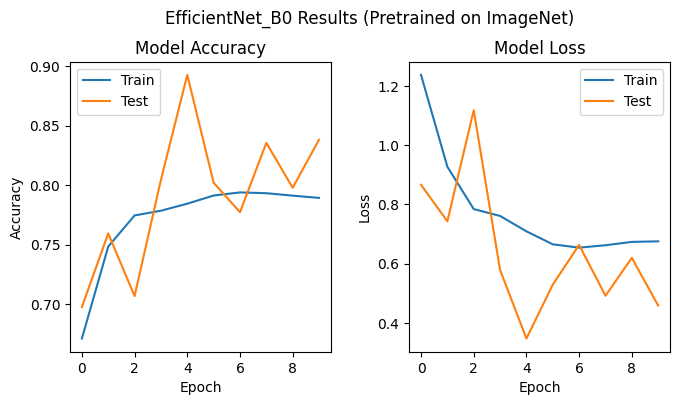

In [46]:
import matplotlib.pyplot as plt

def get_title():
  if PRETRAIN_WEIGHTS is None:
    weights_name = 'From Scratch'
  else:
    weights_name = 'Pretrained on ImageNet'
  return f'{MODEL_NAME} Results ({weights_name})'

def plot_accuracy(hist, ax):
  ax.plot(hist.history['accuracy'])
  ax.plot(hist.history['val_accuracy'])
  ax.set_title('Model Accuracy')
  ax.set_ylabel('Accuracy')
  ax.set_xlabel('Epoch')
  ax.legend(['Train', 'Test'], loc='upper left')


def plot_loss(hist, ax):
  ax.plot(hist.history['loss'])
  ax.plot(hist.history['val_loss'])
  ax.set_title('Model Loss')
  ax.set_ylabel('Loss')
  ax.set_xlabel('Epoch')
  ax.legend(['Train', 'Test'], loc='upper right')

fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle(get_title())
plt.subplots_adjust(left=0, right=1, wspace=0.3, top=0.85)
fig.set_dpi(100)
plot_accuracy(history, ax1)
plot_loss(history, ax2)
plt.show()